<a href="https://colab.research.google.com/github/IvanPP1018/SIMULACION-1/blob/main/Metropolis-Hastings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Metropolis-Hastings**



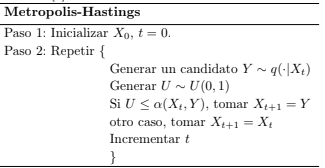

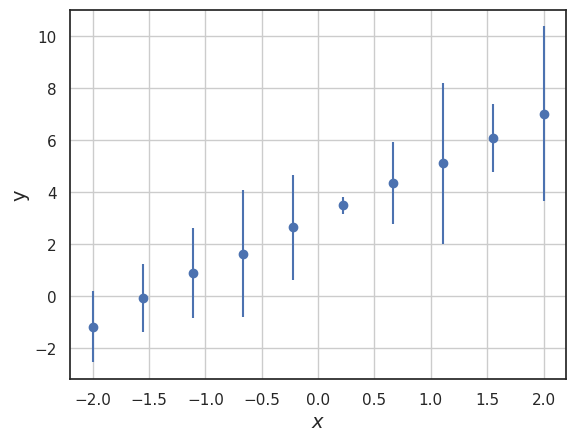

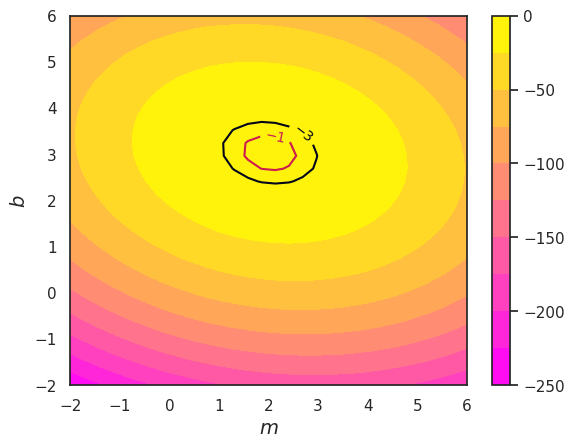

Aceptance rate 0.895
Aceptance rate 0.8505
Aceptance rate 0.5705
Aceptance rate 0.659


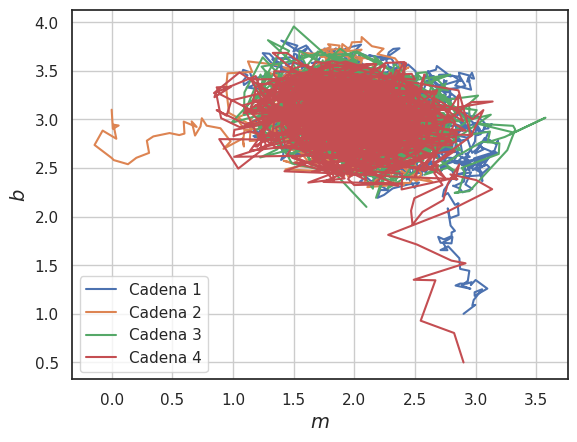

[[ 0.1520314  -0.00954926]
 [-0.00954926  0.07851859]]
                 x            y
count  2001.000000  2001.000000
mean      1.951422     3.027087
std       0.389912     0.280212
min      -0.140976     2.303496
25%       1.745121     2.847841
50%       1.972881     3.004554
75%       2.225393     3.206748
max       2.753067     3.847481
Gelman-Rubin Diagnostic: [1.04356778 1.00068842] [2.06646995 3.02735786] [0.15357097 0.08140456]


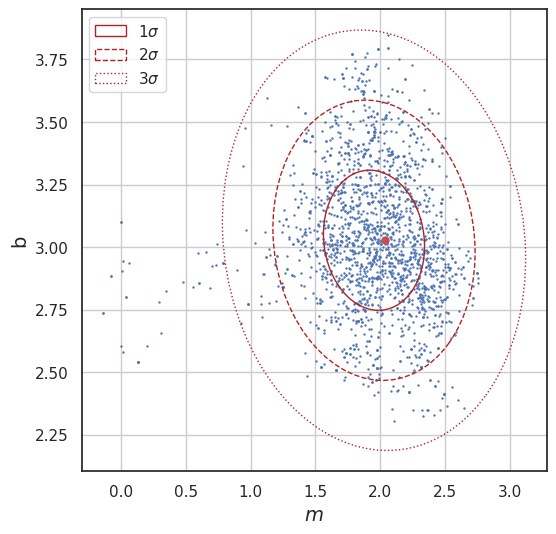

In [1]:
import matplotlib.pyplot as plt
import scipy.stats as st
import seaborn as sb
import pandas as pd
import numpy as np

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from matplotlib import animation, rc
from IPython.display import HTML

%matplotlib inline
sb.set()

# Generación del conjunto de datos sintéticos
r = np.linspace(-2, 2, 10)
m = 2
b = 3

np.random.seed(100)
dispersion = np.random.normal(0.0, 0.1, size=len(r))
function = m * r + b + dispersion
error = np.abs(np.random.normal(0.0, 3, size=len(r)))  # Tomamos el valor absoluto de los errores

# Configuración del estilo del gráfico
sb.set_style("white", {'axes.grid': True})
plt.errorbar(r, function, error, fmt='o')
plt.ylabel('y', fontsize=14)
plt.xlabel('$x$', fontsize=14)
plt.savefig("DatosSinteticos.jpg")
plt.show()

# Creación del DataFrame
df = pd.DataFrame({'x': r, 'f': function, 'error': error})
s = df['error'] ** 2
covariance = pd.DataFrame(np.diag(s), index=s.index, columns=s.index)

# Definición del modelo teórico
def theory(x, m=2, b=3):
    return m * x + b

# Definición del loglikelihood para valores particulares de los parámetros
def loglike(m=2, b=3):
    delta = theory(df['x'], m, b) - df['f']
    chisquare = np.dot(delta, np.dot(np.linalg.inv(covariance), delta))
    return -chisquare / 2.

# Generación de la gráfica de contornos
x = np.linspace(-2, 6, 30)
y = np.linspace(-2, 6, 30)

grid = np.array([[loglike(m, b=i) for m in x] for i in y])
fig, ax = plt.subplots()
gs = ax.contourf(x, y, grid, 10, cmap='spring')
cbar = fig.colorbar(gs)

CS = ax.contour(x, y, grid, np.arange(-3., 3, 2))
ax.clabel(CS, inline=10, fontsize=10)

plt.ylabel('$b$', fontsize=14)
plt.xlabel('$m$', fontsize=14)
plt.savefig("GraficaContornos.jpg")
plt.show()

# Redefinición de la función loglike
def loglike(params):
    m = params[0]
    b = params[1]
    delta = theory(df['x'], m=m, b=b) - df['f']
    chisquare = np.dot(delta, np.dot(np.linalg.inv(covariance), delta))
    return -chisquare / 2.

# Definición del algoritmo MCMC
def target(lik, prior, theta):
    return lik(theta)

def metropolissampler(niters, lik, prior, theta, sigma):
    accepted = 0
    samples = []
    likeli = []

    samples.append(theta)
    likeli.append(target(lik, prior, theta))

    for i in range(niters):
        theta_p = theta + sigma * np.random.normal(0., 1., len(theta))
        likeratio = np.exp(target(lik, prior, theta_p) - target(lik, prior, theta))
        rho = np.minimum(1, likeratio)

        if rho > np.random.uniform():
            theta = theta_p
            accepted += 1

        samples.append(theta)
        likeli.append(target(lik, prior, theta))

    print('Aceptance rate', 1.0 * accepted / niters)
    return samples

# Parámetros para las cadenas de Markov
lik = loglike
sigma = [[0.06, 0.06], [0.1, 0.1], [0.3, 0.3], [0.3, 0.2]]
theta = [[2.9, 1.], [0., 3.1], [2.1, 2.1], [2.9, 0.5]]
niters = 2000
prior = st.uniform(1)
nchains = 4
cadenas = []

sb.set_style("white", {'axes.grid': True})

for i in range(nchains):
    cadenas.append(metropolissampler(niters, lik, prior, theta[i], sigma[i]))
    plt.plot([c[0] for c in cadenas[i]], [c[1] for c in cadenas[i]], label="Cadena " + str(i+1))

plt.ylabel('$b$', fontsize=14)
plt.xlabel('$m$', fontsize=14)
plt.legend()
plt.savefig("MuestreoparaMCMC.jpg")
plt.show()

# Generación de las regiones de confianza
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
                      width=ell_radius_x * 2,
                      height=ell_radius_y * 2,
                      facecolor=facecolor,
                      **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

fig, ax_nstd = plt.subplots(figsize=(6, 6))
x = np.array([c[0] for c in cadenas[1]])
y = np.array([c[1] for c in cadenas[1]])
ax_nstd.scatter(x, y, s=0.5)
confidence_ellipse(x, y, ax_nstd, n_std=1, label=r'$1\sigma$', edgecolor='firebrick')
confidence_ellipse(x, y, ax_nstd, n_std=2, label=r'$2\sigma$', edgecolor='firebrick', linestyle='--')
confidence_ellipse(x, y, ax_nstd, n_std=3, label=r'$3\sigma$', edgecolor='firebrick', linestyle=':')
ax_nstd.legend()

print(np.cov(x, y))
dg = pd.DataFrame({'x': x, 'y': y})
print(dg.describe())

sb.set_style("white", {'axes.grid': True})
plt.ylabel('b', fontsize=14)
plt.xlabel('$m$', fontsize=14)
plt.scatter(2.040, 3.029, s=25, color='r')
plt.savefig("Elipsesdeconfianza.jpg")

# Prueba Gelman-Rubin
chains = np.array(cadenas)

mean_chain = []
var_chain = []

n_chains, n_steps, n_params = np.shape(chains)
bi = int(n_steps * 0.1)

for chain in chains:
    mean_chain.append(np.mean(chain[bi:], axis=0))
    var_chain.append(np.var(chain[bi:], axis=0))

M = np.mean(mean_chain, axis=0)
W = np.mean(var_chain, axis=0)

B = 0
for i in range(n_chains):
    B += (mean_chain[i] - M) ** 2

B = n_steps / (n_chains - 1) * B
R = (1 - 1. / n_steps) * W + B / n_steps

print('Gelman-Rubin Diagnostic:', np.sqrt(R / W), M, W)


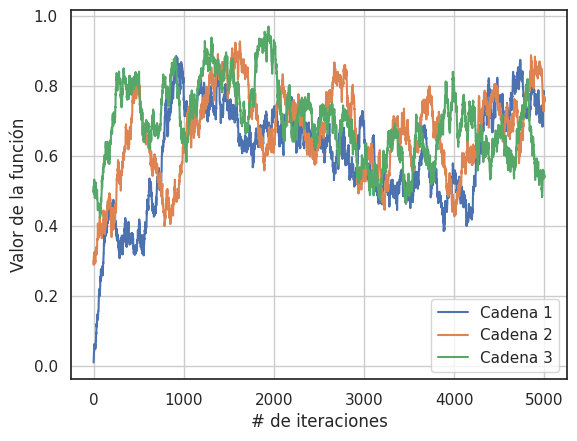

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
#se define funcion objetivo
def target(lik, prior, param, theta):
    if theta < 0 or theta >1:
        return 0
    else:
        return lik(param[0], theta).pmf(param[1])*prior.pdf(theta)
def metropolissampler(niters, lik, prior, theta, param, sigma):
    samples = np.zeros(niters+1)
    samples[0] = theta

    for i in range(niters):
        theta_p = theta + st.norm(0, sigma).rvs()
        rho = min(1, target(lik, prior, param, theta_p)/target(lik, prior, param, theta))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples[i+1] = theta
    return samples

    #nmcmc = len(samples)//2
param = [14,10] #14 trials and 10 heads

#params beta function

prior = st.beta(1,1)
#se define el likelihood como una dist binomial
#por tratarse del volado

lik = st.binom
#prior = st.beta(a,b) #prior que obedece dist beta a=1, b=1.
sigma = 0.01 #std dev

theta = [0.01,0.3,0.5] # guess for p

niters = 5000

cadenas=[]
nchains = 3

for i in range(nchains):
    cadenas.append(metropolissampler(niters, lik, prior, theta[i], param, sigma))
    plt.plot(cadenas[i], '-', label = "Cadena "+str(i+1))

plt.xlabel("# de iteraciones")
plt.ylabel("Valor de la función")
plt.legend()

plt.savefig('convergencia.png')

plt.show()
